## This is an end to end example of using ArcGIS with python 
this has been mostly followed as a simplefied version from here https://github.com/orhuna/RF-Demo/blob/master/RF_Demo_Fl.ipynb

For better visualization, maps have been published into the GIS server with a public read access to display it in the notebook cell



In [13]:
from sklearn.ensemble import RandomForestClassifier
import numpy as NUM
import arcpy as ARCPY
import arcpy.da as DA
import pandas as PD
import seaborn as SEA
import matplotlib.pyplot as PLOT
import pandas as PD
import arcgisscripting as ARC
import arcpy as ARCPY
import SSUtilities as UTILS
from arcgis.gis import *
import os as OS

In [14]:
mygis = GIS()

In [15]:
from IPython.display import IFrame  
def show_web_map_by_url(URL):
    url = 'http://www.arcgis.com/home/webmap/viewer.html?url=' + URL
    return IFrame(url, width='100%', height=500)  

In [16]:
analysis_map_URL = 'https://services3.arcgis.com/oZfKvdlWHN1MwS48/ArcGIS/rest/services/MachineLearningSeagrass/FeatureServer/1&source=sd'

This is the initial map which has florida data to start the data analysis 

In [17]:
#Where the seagrasses are in florida

show_web_map_by_url(analysis_map_URL)

In [18]:
#Load the features from the shapefile stored in GIS Desktop
inputDir = 'C:/GISDemo/SeaGrass/SeaGrass.gdb/FloridaSeaGrass'


In [19]:
#Names of Prediction Variables
predictVars = ['salinity', 'temp', 'phosphate','nitrate', 
               'silicate', 'dissO2', 'NameEMU']
#Name of Classification Variable
classVar = ['Present']
#List of all Variables
allVars = predictVars + classVar

In [20]:
#GIS data to Pandas dataframe

#Get Data from ArcGIS Desktop
FlLayer = DA.FeatureClassToNumPyArray(inputDir, ["SHAPE@XY"] + allVars)
#Obtain Spatial Reference
spatRef = ARCPY.Describe(inputDir).spatialReference
#Define Main Dataframe
data = PD.DataFrame(FlLayer, columns = allVars)
#Display Portion of the Data Frame
data.head()

,salinity,temp,phosphate,nitrate,silicate,dissO2,NameEMU,Present
0,35.694950,24.75329,0.070516,0.503541,3.878356,5.038187,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0
1,35.985001,24.13740,0.124987,0.836354,1.521608,4.710738,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0
2,35.581039,18.00565,1.032444,15.172270,10.742860,3.839985,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1
3,35.469360,14.55408,0.936634,14.109170,9.925514,3.654587,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1
4,35.413799,13.48950,0.980522,14.746720,10.737210,3.721700,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0


In [21]:
#Process Categorical Data for Analysis flatten the categorical data 
#Create Numeric Fields for One-Hot Encoding of the Categorical Variable
catVars = PD.get_dummies(data[predictVars[-1]])

In [22]:
#Remove raw Categories from Dataset
data = data.drop(predictVars[-1], axis = 1)
#Add Processed Categories Back into the Data Frame
data = data.join(catVars)
#Abbreviate Long Categorical Variable Names
newNames = ['c1','c2','c3']
for ind, name in enumerate(newNames):
    data.rename(columns={data.columns[len(predictVars)+ind]:name}, inplace=True)
#Update Predict Variable Names
predictVarsNew = predictVars[:-1] + newNames
#Display Portion of the Data Frame
data.head()

,salinity,temp,phosphate,nitrate,silicate,dissO2,Present,c1,c2,c3
0,35.694950,24.75329,0.070516,0.503541,3.878356,5.038187,0,0,1,0
1,35.985001,24.13740,0.124987,0.836354,1.521608,4.710738,0,0,1,0
2,35.581039,18.00565,1.032444,15.172270,10.742860,3.839985,1,0,1,0
3,35.469360,14.55408,0.936634,14.109170,9.925514,3.654587,1,0,1,0
4,35.413799,13.48950,0.980522,14.746720,10.737210,3.721700,0,0,1,0


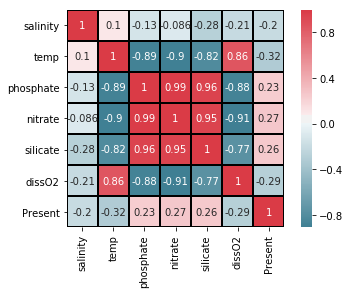

In [23]:
##EVALUATE CORRELATION BETWEEN PREDICTORS- EXCLUDE CATEGORICAL
#Calculate Correlation Coefficient between Prediction Variables
corr = data.drop(data.columns[-3:], axis = 1).astype('float64').corr()

#Plot Correlation Matrix Between Prediction Variables
ax = SEA.heatmap(corr, cmap=SEA.diverging_palette(220, 10, as_cmap=True),
            square=True, annot = True, linecolor = 'k', linewidths = 1)

PLOT.show()

In [29]:
##PERFORM RANDOM FOREST CLASSIFICATION
#Fraction of data to be used in Training
fracNum = 0.3
#Seperate the Data into Training and Test Datasets
train_c1 = data[data[classVar[0]] == 1].sample(frac = fracNum)
train_c0 = data[data[classVar[0]] == 0].sample(frac = fracNum)
#Create Training Dataset
train_set = PD.concat([train_c0, train_c1])
#Create Testing Dataset
test_set = data.drop(train_set.index)
#Encode Seagrass Presence as Classes
indicator, _ = PD.factorize(train_set[classVar[0]])
#Print Test and Train Data Set Sizes
print('Training Data Size = ' + str(train_set.size))
print('Test Data Size = ' + str(test_set.size))

Training Data Size = 300000
Test Data Size = 700000


In [38]:
##Create Random Forest Classification Object
rfco = RandomForestClassifier(n_estimators = 500, oob_score = True)
#Perform Classification Using Training Set
rfco.fit(train_set[predictVars[:-1]], indicator)
#Plot Variable Importance
#Dummy Variables for Y-Ticks


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [41]:
#Predict Seagrass Occurance for the Test Dataset
seagrassPred = rfco.predict(test_set[predictVars[:-1]])
#Calculate Prediction Accuracy
test_seagrass = test_set['Present'].values.flatten()
#Calculate Estimation Error
error = NUM.sum(test_seagrass - seagrassPred)/len(seagrassPred) * 100


In [42]:
#Print Accuracy Metrics
print('Accuracy = ' + str(100 - NUM.abs(error)) + ' % ')
print('Locations with Seagrass = ' + str(len(NUM.where(test_seagrass==1)[0])) )
print('Predicted Locations with Seagrass = ' + str(len(NUM.where(seagrassPred==1)[0])))

Accuracy = 99.66285714285715 % 
Locations with Seagrass = 21612
Predicted Locations with Seagrass = 21376


In [27]:
 #Delete the feature  as ARCPY.da.NumPyArrayToFeatureClass does not overwrite 
#ARCPY.DeleteFeatures_management("C:/GISDemo/SeaGrass/SeaGrass.gdb\Florida_Seagrass_Prediction")

<Result 'C:/GISDemo/SeaGrass/SeaGrass.gdb\\Florida_Seagrass_Prediction'>

In [45]:
##BRING OUTPUT BACK INTO ArcGIS Desktop
#Allow overwriting Feature Classes
ARCPY.env.overwriteOutput = True
#Get Indexes for the Test Dataset
outputDir = r'C:/GISDemo/SeaGrass/SeaGrass.gdb'
nameFC = 'Florida_Seagrass_Prediction_Py'
#Locations with Seagrass
grassExists = FlLayer[["SHAPE@XY"]][test_set.index[NUM.where(seagrassPred==1)]]
# Write Locations with Seagrass to Feature Class
ARCPY.da.NumPyArrayToFeatureClass(grassExists, OS.path.join(outputDir, nameFC), ['SHAPE@XY'], spatRef)

In [15]:
predicted_fl_map_url ='https://www.arcgis.com/home/webmap/viewer.html?webmap=2e65c37b14764e7a875efb5b5bad4633'

In [16]:
IFrame(predicted_fl_map_url, width='100%', height=500)

Now create a model from the USA data set and we will use this to predict the sea grass locations worldwide

In [21]:
#Names of Prediction Variables#Import USA Seagrass Data 
inputDir = 'C:/GISDemo/SeaGrass/SeaGrass.gdb/USASeaGrass_training'
predictVars = ['salinity', 'temp', 'phosphate','nitrate', 
               'silicate', 'dissO2']
#Name of Classification Variable
classVar = ['Present']
#List of all Variables
allVars = predictVars + classVar
#Create a Data Object
USAlayer = DA.FeatureClassToNumPyArray(inputDir, ["SHAPE@XY"] + allVars)
#Obtain Spatial Reference
spatRefGlobal = ARCPY.Describe(inputDir).spatialReference
#Define Main Dataframe
USA_Train = PD.DataFrame(USAlayer, columns = allVars)
#Display Portion of the Data Frame
USA_Train.head()

,salinity,temp,phosphate,nitrate,silicate,dissO2,Present
0,33.757988,8.378799,2.04564,25.473619,35.493446,3.365844,0
1,33.757988,8.378799,2.04564,25.473619,35.493446,3.365844,0
2,33.757988,8.378799,2.04564,25.473619,35.493446,3.365844,0
3,33.757988,8.378799,2.04564,25.473619,35.493446,3.365844,0
4,33.757988,8.378799,2.04564,25.473619,35.493446,3.365844,0


In [22]:
##Train Random Forest Using USA Data
#Encode Seagrass Presence as Classes
indicatorUSA, _ = PD.factorize(USA_Train['Present'])
#Create Random Forest Classification Object
rfco = RandomForestClassifier(n_estimators = 500)
#Perform Classification Using Training Set
rfco.fit(USA_Train[predictVars[:-1]], indicatorUSA)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
predictVars[:-1]


['salinity', 'temp', 'phosphate', 'nitrate', 'silicate']

In [24]:
## Import Global Data for Prediction ##
##globalUrl = r'https://services3.arcgis.com/oZfKvdlWHN1MwS48/arcgis/rest/services/MachineLearningSeagrass/FeatureServer/2?token=W4CSlYAQxBZKNONRrS_MVm0qNa7j21xD5BNMByQOuXTQ6xhXxFydToukAXYrndK0RRrMNjvbFHcbCOioIVNAgIe6f0iV7rclZ4kNGqoI3i1Ldjhv_UgwzeBGc7KJacuAshcwYXkb6PIgrGipbwD3YOV3AGhhRmh9e5RzMSWB7HJS9fSYzU2l8ZL9vkLmWccKvo_DGJaqm9GIkz9HoPM2hv2yGDdf9SEtcoQvBsNkCWk.'
globalUrl = 'C:/GISDemo/SeaGrass/SeaGrass.gdb/Global_Seagrass_Prediction'
#Create a SS Data Object
globalData = DA.FeatureClassToNumPyArray(globalUrl, ["SHAPE@XY"] + predictVars[:-1])
#Obtain Spatial Reference
spatRefGlobal = ARCPY.Describe(globalUrl).spatialReference
#Define Dataframe
globalTrain = PD.DataFrame(globalData, columns = predictVars[:-1])

In [28]:
#Predict Global Seagrass Occurance
seagrassPredGlobal = rfco.predict(globalTrain)
#Bring Output Back to ArcGIS
nameFC = 'GlobSeagrass'
outputDir = r'C:/GISDemo/SeaGrass/SeaGrass.gdb'
nameFC = 'Global_Seagrass_Prediction_Done'
grassExists = globalData[["SHAPE@XY"]][globalTrain.index[NUM.where(seagrassPredGlobal==1)]]
# Write Locations with Seagrass to Feature Class
ARCPY.da.NumPyArrayToFeatureClass(grassExists, OS.path.join(outputDir, nameFC), ['SHAPE@XY'], spatRefGlobal)


In [29]:
predicted_gl_map_url='https://www.arcgis.com/home/webmap/viewer.html?webmap=503efd8acb7b48e3b92b4f4ac4d6e82e'

Global prediction data as shown on the map

In [30]:
IFrame(predicted_gl_map_url, width='100%', height=500)